# Using SciKit Learn's Random Forest Classifier to find out which features we can use to separate DFG-in vs. DFG-out from manualy classified Src and Abl PDB structures

In [1]:
#Special thanks to Josh Fass for his advice on this 
#(originally code for something similar was written by him using the Decision Tree Function)

In [2]:
import mdtraj as md
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

import re
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#We are going to be using pyemma's featurizers for this since they also include the indices to pull out afterward
import pyemma.coordinates

In [4]:
#We'll start with our ABL structures
# get filenames of the trajectories
files = glob('Abl*/*.pdb')
print(len(files),files[0])

(76, 'Abl_DFG_in/ABL1_HUMAN_D0_2F4J_A.pdb')


In [5]:
traj = md.load(files[0])
top = traj.top

In [6]:
top.n_atoms

2043

In [7]:
feat = pyemma.coordinates.featurizer(files[0])

In [8]:
def FeaturizeAndClassify(files):
    Xs = []
    ys = []

    feat = pyemma.coordinates.featurizer(files[0])
    feat.add_chi1_torsions(cossin=True)
    feat.add_backbone_torsions(cossin=True)
    print feat.dimension()
    
    for filename in files:
        state_string = re.findall('DFG_[\w]*',filename)

        try:
            traj = md.load(filename)
            x = feat.transform(traj)
            Xs.append(x) #needed to use list(x) at one point to convert to numpy array later
            ys.append(state_string)
        except:
            pass
        
    print 'These should be the same: %s,%s'%(len(Xs),len(files))
        
    X = np.vstack(Xs)
    y = np.hstack(ys)
    
    print 'These should have the same first dimension: %s,%s,%s'%(X.shape,y.shape,len(set(y)))
    
    #Before we can use decision tree we need to transform our categorical 
    # parameters ('DFG_in' and 'DFG_out') to numerical parameters
    
    le = preprocessing.LabelEncoder()
    le.fit(['DFG_in','DFG_out'])
    print 'These are our classes: %s' %list(le.classes_)
    y = le.transform(y)
    # le.inverse_transform(y) can be used to get back your original labels
    
    return [X,y,le,feat]

In [9]:
[X,y,le,feat] = FeaturizeAndClassify(files)

1440
These should be the same: 76,76
These should have the same first dimension: (76, 1440),(76,),2
These are our classes: ['DFG_in', 'DFG_out']


### No we can build our random forest.

In [10]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [11]:
dt.score(X,y)

1.0

In [12]:
dt.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

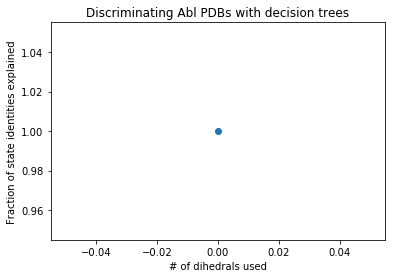

In [13]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(dt.feature_importances_[dt.feature_importances_!=0])[::-1])*dt.score(X,y), marker = 'o')
#plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of dihedrals used')
plt.ylabel('Fraction of state identities explained')
plt.title('Discriminating Abl PDBs with decision trees')

How do we find out what this dihedral is with this pyemma object?

In [14]:
feature_importances = dt.feature_importances_[dt.feature_importances_!=0]
sorted_inds = np.array(sorted(np.arange(len(feature_importances)),key=lambda i:-feature_importances[i]))

In [15]:
sorted_inds

array([0])

In [16]:
features = feat.describe()

In [17]:
features[sorted_inds]

/Users/hansons/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':


'COS(CHI1 0 ILE 1 )'

In [18]:
# Is this right???  # Does Decision tree just give us the first feature back???

## Let's try Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
clf = RandomForestClassifier(n_estimators=10,max_depth=None,
  min_samples_split=2, random_state=0)
clf = clf.fit(X,y)

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
scores = cross_val_score(clf, X, y)

In [23]:
scores

array([ 0.84615385,  0.92      ,  0.96      ])

In [24]:
scores.mean()

0.90871794871794875

In [25]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [26]:
clf.score(X,y)

1.0

In [27]:
clf.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

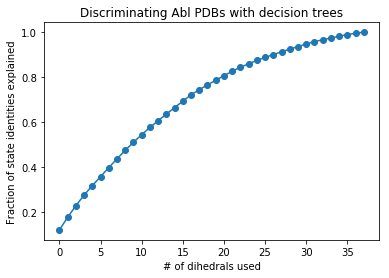

In [28]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(clf.feature_importances_[clf.feature_importances_!=0])[::-1])*clf.score(X,y), marker = 'o')
#plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of dihedrals used')
plt.ylabel('Fraction of state identities explained')
plt.title('Discriminating Abl PDBs with decision trees')

In [29]:
clf.feature_importances_[clf.feature_importances_!=0]

array([ 0.03414141,  0.021375  ,  0.04013169,  0.00816523,  0.01138496,
        0.02296965,  0.0285    ,  0.01993443,  0.00631579,  0.03816149,
        0.05637302,  0.02868202,  0.04226447,  0.02977851,  0.0178125 ,
        0.02084058,  0.02843167,  0.011875  ,  0.01262878,  0.01298137,
        0.01091618,  0.00415641,  0.0199446 ,  0.04003756,  0.04725185,
        0.05148214,  0.02982732,  0.03912185,  0.03214286,  0.01526786,
        0.03544899,  0.00784229,  0.11932437,  0.00778017,  0.0113659 ,
        0.00744196,  0.01552732,  0.01237281])

In [30]:
len (clf.feature_importances_[clf.feature_importances_!=0])

38

In [31]:
# get indices
non_zero_indices = [i for i,x in enumerate(clf.feature_importances_!=0) if x]

In [32]:
len(non_zero_indices)

38

In [33]:
non_zero_indices

[70,
 104,
 214,
 218,
 222,
 322,
 352,
 356,
 418,
 458,
 462,
 464,
 474,
 484,
 637,
 714,
 754,
 762,
 818,
 834,
 872,
 900,
 918,
 991,
 996,
 1000,
 1026,
 1046,
 1048,
 1062,
 1072,
 1081,
 1134,
 1241,
 1253,
 1270,
 1350,
 1365]

In [34]:
# Let's get sorted non-zero-indices
sorted_importance = sorted(clf.feature_importances_[clf.feature_importances_!=0])

In [35]:
sorted_non_zero_indices = []
for value in sorted_importance:
    for i,x in enumerate(clf.feature_importances_):
        if x == value:
            sorted_non_zero_indices.append(i)
        else:
            pass

In [36]:
sorted_non_zero_indices

[900,
 418,
 1270,
 1241,
 1081,
 218,
 872,
 1253,
 222,
 762,
 1365,
 818,
 834,
 1062,
 1350,
 637,
 356,
 918,
 714,
 104,
 322,
 754,
 352,
 464,
 484,
 1026,
 1048,
 70,
 1072,
 458,
 1046,
 991,
 214,
 474,
 996,
 1000,
 462,
 1134]

In [37]:
for index in sorted_non_zero_indices:
    print feat.describe()[index]
    print clf.feature_importances_[index]

COS(PHI 0 PHE 118)
0.00415641235986
COS(CHI1 0 ARG 242 )
0.00631578947368
COS(PSI 0 GLU 209)
0.00744195983478
SIN(PHI 0 ASP 203)
0.00778017241379
SIN(PHI 0 LYS 163)
0.00784228747143
COS(CHI1 0 LEU 123 )
0.00816523108271
COS(PHI 0 GLU 111)
0.0109161793372
SIN(PHI 0 GLN 206)
0.0113659022931
COS(CHI1 0 ASN 127 )
0.0113849555944
COS(PSI 0 LEU 82)
0.011875
SIN(PHI 0 CYS 234)
0.0123728123728
COS(PSI 0 ALA 96)
0.0126287803257
COS(PSI 0 LEU 100)
0.0129813664596
COS(PSI 0 GLY 157)
0.0152678571429
COS(PSI 0 GLU 229)
0.0155273246819
SIN(PHI 0 ILE 52)
0.0178125
COS(CHI1 0 GLU 209 )
0.0199344262295
COS(PSI 0 ARG 121)
0.019944598338
COS(PSI 0 PHE 70)
0.0208405842957
COS(CHI1 0 LEU 61 )
0.021375
COS(CHI1 0 TRP 189 )
0.0229696472518
COS(PSI 0 GLY 80)
0.0284316692779
COS(CHI1 0 VAL 207 )
0.0285
COS(PHI 0 GLY 9)
0.0286820187097
COS(PHI 0 GLU 14)
0.0297785069729
COS(PSI 0 THR 148)
0.0298273155416
COS(PHI 0 HIS 155)
0.0321428571429
COS(CHI1 0 PHE 42 )
0.0341414141414
COS(PHI 0 PRO 161)
0.0354489852186
COS